# Assets Monitored with Route Designation

**Category:** Route Table
**Scope:** Site-Specific   
**Author:** Michael Moyer   
**Created:** 01-13-2026   
**Last Updated:** 01-13-2026  

**Purpose:** Identifies Assets on routes coded correctly

Notebook gathers the data, organizes, cleans and provides a brief report on it. 
        
**Use Case:** Use this notebook to detect assets with Condition Monitoring according to 000 standard.

---

In [1]:
NOTEBOOK_NAME = 'acm_assets_routes-coverage'
sql_file = f'{NOTEBOOK_NAME}.sql'

## Step 0: Load Packages and SQL Script

### 0.0 Package Load

In [2]:
import pandas as pd
import os
import pyodbc
import re

from dotenv import load_dotenv, find_dotenv
from pathlib import Path


import warnings
import time       # for timing longer cells (running the sql query)
import matplotlib.pyplot as plt
from datetime import datetime

### 0.1 Credentials Load

In [3]:
# Automatically search for .env in parent directories
load_dotenv(find_dotenv())

# Load from environment variables
DSN = os.getenv('MAXIMO_DSN')
USER = os.getenv('MAXIMO_USER')
PASSWORD = os.getenv('MAXIMO_PASS')

print(f"DSN: {DSN}")
print(f"User: {USER}")

DSN: MX76PROD
User: maximo7


### 0.2 Define Query Pull Function

In [4]:
# Suppress the pandas warning
warnings.filterwarnings('ignore', category=UserWarning)

def run_query_from_file(sql_path: str) -> pd.DataFrame:
    conn = pyodbc.connect(f"DSN={DSN};UID={USER};PWD={PASSWORD}")
    query = open(sql_path).read()
    df = pd.read_sql(query, conn)
    conn.close()
    return df

## Step 1: Pull Data
### 1.1 Run & Time the Query

Check the file names

In [5]:
print(f"Notebook: {NOTEBOOK_NAME}.ipynb")
print(f"Matching Script: {sql_file}")

Notebook: acm_assets_routes-coverage.ipynb
Matching Script: acm_assets_routes-coverage.sql


Run the query and time the execution of it.

In [6]:
# Start timing
start_time = time.time()

# Run the sql script
df_raw = run_query_from_file(sql_file)

# Calculate and print execution time
execution_time = time.time() - start_time
print(f"Query execution time: {execution_time:.2f} seconds \n")

Query execution time: 3.12 seconds 



### 1.2 Basic Shape / Information

In [7]:
print(f"Raw Data Frame Shape: {df_raw.shape[0]:,} rows, {df_raw.shape[1]} columns \n")
print("--- DataFrame Info---\n")
print(df_raw.info(), "\n\n--- null value detection---\n\n", df_raw.isna().sum())
#Memory Usage
print("")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Raw Data Frame Shape: 2,370 rows, 6 columns 

--- DataFrame Info---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROUTE       2370 non-null   object
 1   ROUTE_DESC  2370 non-null   object
 2   ASSETNUM    2370 non-null   object
 3   ASSET_DESC  2370 non-null   object
 4   CLASS       2370 non-null   object
 5   DEPT        2370 non-null   object
dtypes: object(6)
memory usage: 111.2+ KB
None 

--- null value detection---

 ROUTE         0
ROUTE_DESC    0
ASSETNUM      0
ASSET_DESC    0
CLASS         0
DEPT          0
dtype: int64

Memory usage: 0.92 MB


### 1.3 Asses Missingness (remove 100% empty columns)

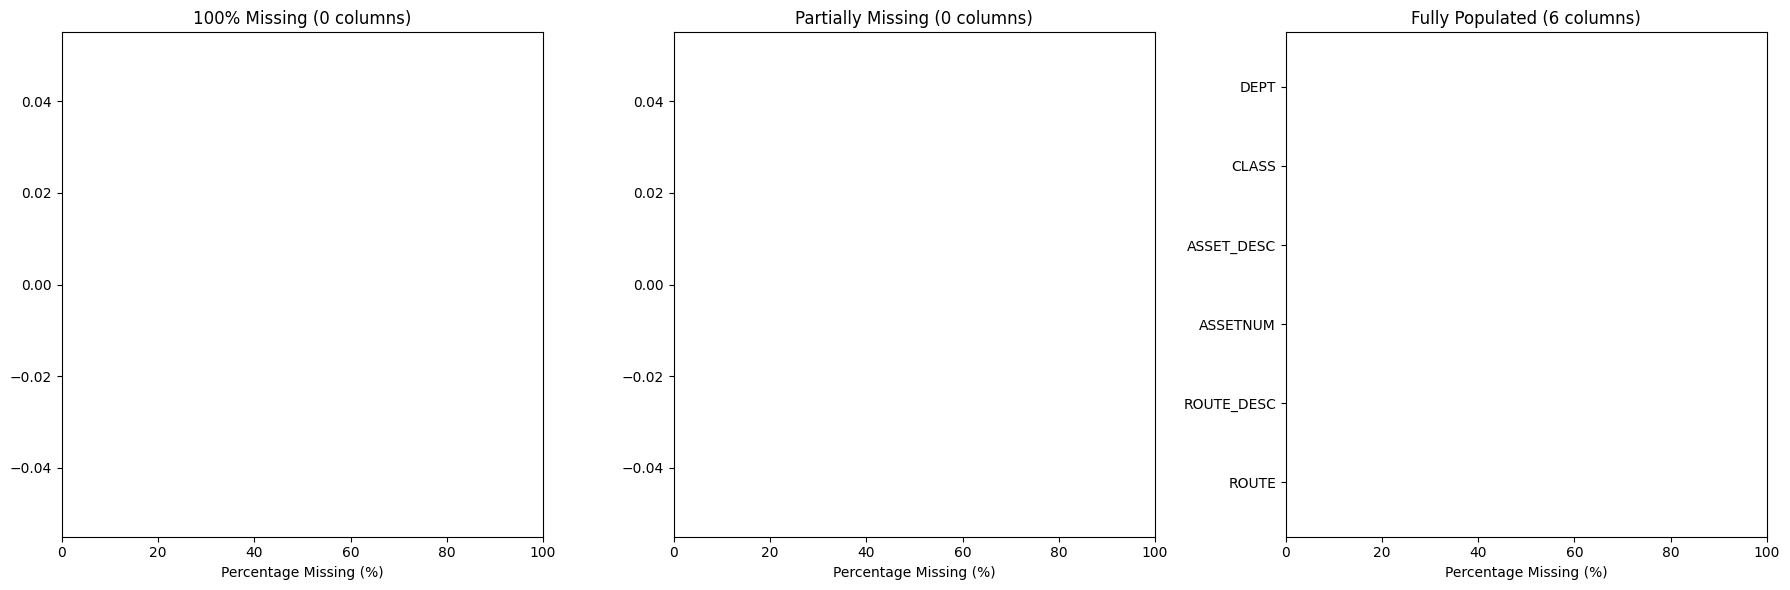

In [8]:
#Converting to dataframe
missing_df_raw = df_raw.isna().sum().to_frame(name='count')

#Add column for percentage of total that are missing
missing_df_raw['percentage'] =  100 - (((df_raw.shape[0] - missing_df_raw['count'])/df_raw.shape[0]) * 100)

# Sort by percentage descending
# Separate into three categories
missing_100 = missing_df_raw[missing_df_raw['percentage'] == 100].sort_values('percentage', ascending=False)
missing_partial = missing_df_raw[(missing_df_raw['percentage'] > 0) & (missing_df_raw['percentage'] < 100)].sort_values('percentage', ascending=False)
missing_0 = missing_df_raw[missing_df_raw['percentage'] == 0].sort_values('percentage', ascending=False)

# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Chart 1: 100% missing
axes[0].barh(missing_100.index, missing_100['percentage'], color='red')
axes[0].set_xlabel('Percentage Missing (%)')
axes[0].set_title(f'100% Missing ({len(missing_100)} columns)')
axes[0].set_xlim(0, 100)

# Chart 2: Partial missing
axes[1].barh(missing_partial.index, missing_partial['percentage'], color='orange')
axes[1].set_xlabel('Percentage Missing (%)')
axes[1].set_title(f'Partially Missing ({len(missing_partial)} columns)')
axes[1].set_xlim(0, 100)

# Chart 3: 0% missing (fully populated)
axes[2].barh(missing_0.index, missing_0['percentage'], color='green')
axes[2].set_xlabel('Percentage Missing (%)')
axes[2].set_title(f'Fully Populated ({len(missing_0)} columns)')
axes[2].set_xlim(0, 100)

plt.tight_layout()
plt.show()

In [10]:
display(missing_df_raw)

,count,percentage
ROUTE,0,0.0
ROUTE_DESC,0,0.0
ASSETNUM,0,0.0
ASSET_DESC,0,0.0
CLASS,0,0.0
DEPT,0,0.0


## Step 2: Clean & Inspect Data
### 2.1 Dtype Conversion

In [9]:
# Primary Conversions
df_raw['ROUTE'] = df_raw['ROUTE'].astype('category')
df_raw['ASSETNUM'] = df_raw['ASSETNUM'].astype('category')
df_raw['CLASS'] = df_raw['CLASS'].astype('category')


# Verify
print(df_raw.info())

#Memory Usage
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ROUTE       2370 non-null   category
 1   ROUTE_DESC  2370 non-null   object  
 2   ASSETNUM    2370 non-null   category
 3   ASSET_DESC  2370 non-null   object  
 4   CLASS       2370 non-null   category
 5   DEPT        2370 non-null   object  
dtypes: category(3), object(3)
memory usage: 112.8+ KB
None
Memory usage: 0.66 MB


In [10]:
df_raw.head(5)

,ROUTE,ROUTE_DESC,ASSETNUM,ASSET_DESC,CLASS,DEPT
0,RT105093,"2WE_IR_FLIR - A1 ZONE SCANS - MASTER, SERVO, C...",A216509,"A1, W12 CONVEYOR, MASTER CONTROL PANEL, MCP",Panel,2WE
1,RT105093,"2WE_IR_FLIR - A1 ZONE SCANS - MASTER, SERVO, C...",A216510,"A1, W13 CONVEYOR, MASTER CONTROL PANEL, MCP",Panel,2WE
2,RT105093,"2WE_IR_FLIR - A1 ZONE SCANS - MASTER, SERVO, C...",A216511,"A1, W14 CONVEYOR, MASTER CONTROL PANEL, MCP",Panel,2WE
3,RT105093,"2WE_IR_FLIR - A1 ZONE SCANS - MASTER, SERVO, C...",A216512,"A1, W15 CONVEYOR, MASTER CONTROL PANEL, MCP",Panel,2WE
4,RT105093,"2WE_IR_FLIR - A1 ZONE SCANS - MASTER, SERVO, C...",A216513,"A1, W16 CONVEYOR, MASTER CONTROL PANEL, MCP",Panel,2WE


In [11]:
# Export to CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
csv_filename = f'{NOTEBOOK_NAME}_{timestamp}.csv'
df_raw.to_csv(csv_filename, index=False)

print(f"\nAll records exported to: {csv_filename}")
print(f"Total records exported: {len(df_raw)}")


All records exported to: acm_assets_routes-coverage_20260123_1246.csv
Total records exported: 2370


In [12]:
df_raw.nunique()

ROUTE           91
ROUTE_DESC      91
ASSETNUM      1466
ASSET_DESC    1464
CLASS           46
DEPT            13
dtype: int64

In [13]:
# Step 1: Parse the route description to extract technology code
# Pattern: {DEPT}_{TECH}_{SUBTYPE} - Description
def extract_tech_from_route(route_desc):
    """
    Extract technology code from route description
    Example: '2PA_UL_UEDMS - Penthouse Route 1' -> 'UL'
    """
    # Better null check for pandas
    if not isinstance(route_desc, str):
        return None
    
    # Match pattern: XXX_YY_ZZZ where YY is the tech code
    match = re.match(r'^([A-Z0-9]+)_([A-Z0-9]+)_([A-Z0-9]+)\s*-', route_desc)
    if match:
        tech = match.group(2)  # Get the second part (tech code)
        return tech
    return None

def extract_dept_from_route(route_desc):
    """
    Extract department code from route description
    Example: '2PA_UL_UEDMS - Penthouse Route 1' -> '2PA'
    """
    if not isinstance(route_desc, str):
        return None
    
    match = re.match(r'^([A-Z0-9]+)_([A-Z0-9]+)_([A-Z0-9]+)\s*-', route_desc)
    if match:
        return match.group(1)  # First part is DEPT
    return None

def extract_vendor_from_route(route_desc):
    """
    Extract vendor code from route description
    Example: '2PA_UL_UEDMS - Penthouse Route 1' -> 'UEDMS'
    """
    if not isinstance(route_desc, str):
        return None
    
    match = re.match(r'^([A-Z0-9]+)_([A-Z0-9]+)_([A-Z0-9]+)\s*-', route_desc)
    if match:
        return match.group(3)  # Third part is VENDOR
    return None



In [14]:
df = df_raw.copy()

In [15]:
# Cell 4: Apply the function to create TECH column
df['TECH'] = df['ROUTE_DESC'].apply(extract_tech_from_route)
df['ROUTE_DEPT'] = df['ROUTE_DESC'].apply(extract_dept_from_route)
df['VENDOR'] = df['ROUTE_DESC'].apply(extract_vendor_from_route)

# Look at results
df[['ROUTE', 'ROUTE_DESC', 'ROUTE_DEPT', 'TECH', 'VENDOR']].drop_duplicates('ROUTE').head(10)

,ROUTE,ROUTE_DESC,ROUTE_DEPT,TECH,VENDOR
0,RT105093,"2WE_IR_FLIR - A1 ZONE SCANS - MASTER, SERVO, C...",2WE,IR,FLIR
17,RT105453,2PA_UL_UEDMS - Penthouse Route 1,2PA,UL,UEDMS
29,RT105454,2PA_UL_UEDMS - Penthouse Route 2,2PA,UL,UEDMS
41,RT105455,2PA_UL_UEDMS - Penthouse Route 3,2PA,UL,UEDMS
54,RT105456,2PA_UL_UEDMS - Penthouse Route 4,2PA,UL,UEDMS
66,RT105457,3EM_IR_FLIR - CrMC Power Cabinet,3EM,IR,FLIR
105,RT105460,3EM_IR_FLIR - CsMC Power Cabinet,3EM,IR,FLIR
181,RT105500,2PA_UL_UEDMS - Ovendeck Route 1,2PA,UL,UEDMS
194,RT105501,2PA_UL_UEDMS - Ovendeck Route 2,2PA,UL,UEDMS
208,RT105502,2PA_UL_UEDMS - Ovendeck Route 3,2PA,UL,UEDMS


In [16]:
# Cell 5: See what technologies we found
print("Technologies found:")
print(df.groupby('TECH')['ASSETNUM'].nunique())

Technologies found:
TECH
IR    950
LU    348
UL    237
VI    529
ZD    105
Name: ASSETNUM, dtype: int64


In [17]:
# Cell 6: Create TWO outputs - summary and detail

# OUTPUT 1: Asset-level summary (one row per asset)
# This keeps the existing structure with Y/N columns
asset_tech = df[df['TECH'].notna()].groupby('ASSETNUM', observed=False)['TECH'].apply(list).reset_index()
asset_tech.columns = ['ASSETNUM', 'TECHNOLOGIES']

# Get asset details
asset_details = df.groupby('ASSETNUM', observed=False).first()[['ASSET_DESC', 'CLASS', 'DEPT']].reset_index()

# Merge together for summary view
asset_coverage = asset_details.merge(asset_tech, on='ASSETNUM', how='left')

# OUTPUT 2: Asset-Tech-Vendor detail (multiple rows per asset)
# This preserves all the granular relationships
asset_tech_vendor_detail = df[df['TECH'].notna()][['ASSETNUM', 'ASSET_DESC', 'CLASS', 'DEPT', 'ROUTE_DEPT', 'TECH', 'VENDOR']].copy()

# Remove duplicates (same asset might be on multiple routes with same tech-vendor combo)
asset_tech_vendor_detail = asset_tech_vendor_detail.drop_duplicates(subset=['ASSETNUM', 'TECH', 'VENDOR'])

# Sort for readability
asset_tech_vendor_detail = asset_tech_vendor_detail.sort_values(['DEPT', 'TECH', 'VENDOR', 'ASSETNUM']).reset_index(drop=True)

print(f"Summary view: {len(asset_coverage)} unique assets")
print(f"Detail view: {len(asset_tech_vendor_detail)} asset-tech-vendor combinations")

Summary view: 1466 unique assets
Detail view: 2252 asset-tech-vendor combinations


In [18]:
# Cell 7: Create HAS columns (Y/N for each technology) - summary view only
# Note: GM (General Metering) comes from a separate SQL Meters query, not included here
for tech in ['IR', 'UL', 'VI', 'LU', 'MC', 'ZD']:  # Removed 'GM'
    col_name = f'{tech}_HAS'
    asset_coverage[col_name] = asset_coverage['TECHNOLOGIES'].apply(
        lambda x: 'Y' if isinstance(x, list) and tech in x else 'N'
    )

# Drop the temporary list column
asset_coverage = asset_coverage.drop('TECHNOLOGIES', axis=1)

# Show summary stats
print("\nAsset Coverage Summary (Route-based monitoring):")
total = len(asset_coverage)
for tech in ['IR', 'UL', 'VI', 'LU', 'MC', 'ZD']:  # Removed 'GM'
    count = (asset_coverage[f'{tech}_HAS'] == 'Y').sum()
    print(f"{tech}: {count} assets ({count/total*100:.1f}%)")
print("\nNote: GM (General Metering) data comes from separate SQL Meters query")


Asset Coverage Summary (Route-based monitoring):
IR: 950 assets (64.8%)
UL: 237 assets (16.2%)
VI: 529 assets (36.1%)
LU: 348 assets (23.7%)
MC: 0 assets (0.0%)
ZD: 105 assets (7.2%)

Note: GM (General Metering) data comes from separate SQL Meters query


In [19]:
# Cell 8: Look at results
asset_coverage.head(20)

,ASSETNUM,ASSET_DESC,CLASS,DEPT,IR_HAS,UL_HAS,VI_HAS,LU_HAS,MC_HAS,ZD_HAS
0,A100001,"PEOPLE MOVER, OHC-1, WT02 PLATFORM",Conveyor,1AF,Y,N,N,N,N,N
1,A100005,KNUCKLE ISLAND BEARING PRESS #2,Press,1AF,Y,N,N,N,N,N
2,A100006,KNUCKLE ISLAND BEARING PRESS #1,Press,1AF,Y,N,N,N,N,N
3,A100024,"RSAT, ELECTRICAL PANEL, HMI 1, CONVEYOR LOAD",Panel,1AF,Y,N,N,N,N,N
4,A100042,SMURF ENGINE SUSPENSION INSTALL ROBOT FANUC MA...,Manipulator,1AF,N,N,N,Y,N,N
5,A100045,SMURF ENGINE SUSPENSION MOUNT MASTER CONTROL ...,Panel,1AF,Y,N,N,N,N,N
6,A100048,D-01 CONTROL PANEL,Panel,1AF,Y,N,N,N,N,N
7,A100102,KNUCKLE CONVEYOR ELECTRICAL PANEL,Panel,1AF,Y,N,N,N,N,N
8,A100126,KNUCKLE ASSEMBLY RKAT ELECTRICAL PANEL,Panel,1AF,Y,N,N,N,N,N
9,A100129,KNUCKLE ASSEMBLY BURNISHING ELECTRICAL PANEL,Panel,1AF,Y,N,N,N,N,N


In [20]:
# Cell 9: Summary stats
total = len(asset_coverage)
for tech in ['IR', 'UL', 'VI', 'LU', 'MC', 'ZD']:
    count = (asset_coverage[f'{tech}_HAS'] == 'Y').sum()
    print(f"{tech}: {count} assets ({count/total*100:.1f}%)")

IR: 950 assets (64.8%)
UL: 237 assets (16.2%)
VI: 529 assets (36.1%)
LU: 348 assets (23.7%)
MC: 0 assets (0.0%)
ZD: 105 assets (7.2%)


In [ ]:
# Cell 10: Save it
#asset_coverage.to_csv('asset_coverage_has.csv', index=False)

In [ ]:
# Export to CSV
OUTPUT_NAME = 'route-coverage'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
csv_filename = f'{OUTPUT_NAME}_{timestamp}.csv'
pkl_filename = f'{OUTPUT_NAME}.pkl'
asset_coverage.to_csv(csv_filename, index=False)
asset_coverage.to_pickle(pkl_filename)
# Detail output (for Streamlit drill-down)
asset_tech_vendor_detail.to_csv(f'asset-tech-vendor-detail_{timestamp}.csv', index=False)
asset_tech_vendor_detail.to_pickle('asset-tech-vendor-detail.pkl')

print(f"\nRoute Coverage records exported to: {csv_filename}")

print(f"\nSummary exported: {len(asset_coverage)} assets")
print(f"Detail exported: {len(asset_tech_vendor_detail)} asset-tech-vendor combos")


All records exported to: route-coverage_20260123_1248.csv
Total records exported: 1466

Summary exported: 1466 assets
Detail exported: 2252 asset-tech-vendor combos
